# Object

* 自分用のNotebookの雛形をまとめる
    * コンペ概要
        * 簡単な背景
        * 何を予測するのか
        * 評価指標
        * 期間
        * 類似コンペ 等
    * 提供データセットの概要
        * カラム
        * サイズ
        * レコード数 等
    * 探索的データ分析
        * 欠損値
        * 分布
        * データセットの結合 等

* 作成の過程で取り組むこと
    * Kaggle Notebookの機能の活用
        * kaggle APIの利用
    * ビジュアライズに有効な手法やライブラリの活用
        * マークダウン
        * 複数のライブラリで視覚化を比較
        * 動きを出すことを意識
    * 英語での表現の習得
        * 日本語と併記しても冗長にならないよう工夫

# Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
# import japanize_matplotlib
import scipy.stats as stats

from pathlib import Path
from matplotlib_venn import venn2

In [2]:
KAGGLE = True if Path().cwd().parent.name == 'kaggle' else False
INPUT = Path('../input')
COMPETITIONS = INPUT / Path('walmart-recruiting-store-sales-forecasting')

In [3]:
FEATURES = pd.read_csv(COMPETITIONS / 'features.csv.zip')
features = FEATURES.copy()
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [4]:
STORES = pd.read_csv(COMPETITIONS / 'stores.csv')
stores = STORES.copy()
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [5]:
sample = pd.read_csv(COMPETITIONS / 'sampleSubmission.csv.zip')
sample.tail()

,Id,Weekly_Sales
115059,45_98_2013-06-28,0
115060,45_98_2013-07-05,0
115061,45_98_2013-07-12,0
115062,45_98_2013-07-19,0
115063,45_98_2013-07-26,0


# Add Features

In [6]:
features['Date'] = features['Date'].astype('datetime64[ns]')
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['dayofweek'] = features['Date'].dt.dayofweek

# EDA

In [7]:
features['year'].value_counts()

year
2011    2340
2012    2340
2010    2160
2013    1350
Name: count, dtype: int64

In [8]:
features[['Store', 'Fuel_Price']].groupby('Store').mean().tail()

,Fuel_Price
Store,
41,3.294401
42,3.615648
43,3.259242
44,3.328764
45,3.476412


In [9]:
for col in ['year', 'month', 'dayofweek']:
    print(col ,': ' , np.sort(features[col].unique()))

year :  [2010 2011 2012 2013]
month :  [ 1  2  3  4  5  6  7  8  9 10 11 12]
dayofweek :  [4]


In [10]:
features[features['Store']==45][['year', 'Fuel_Price']].groupby('year').mean()

,Fuel_Price
year,
2010,2.862854
2011,3.628692
2012,3.766519
2013,3.691300


In [11]:
features[features['Store']==45][['month', 'Fuel_Price']].groupby('month').mean()

,Fuel_Price
month,
1,3.440833
2,3.361063
3,3.561722
4,3.573500
5,3.618353
6,3.490824
7,3.432389
8,3.470154
9,3.482000


In [12]:
features[features['Store']==45][['dayofweek', 'Fuel_Price']].groupby('dayofweek').mean()

,Fuel_Price
dayofweek,
4,3.476412


# Visualize

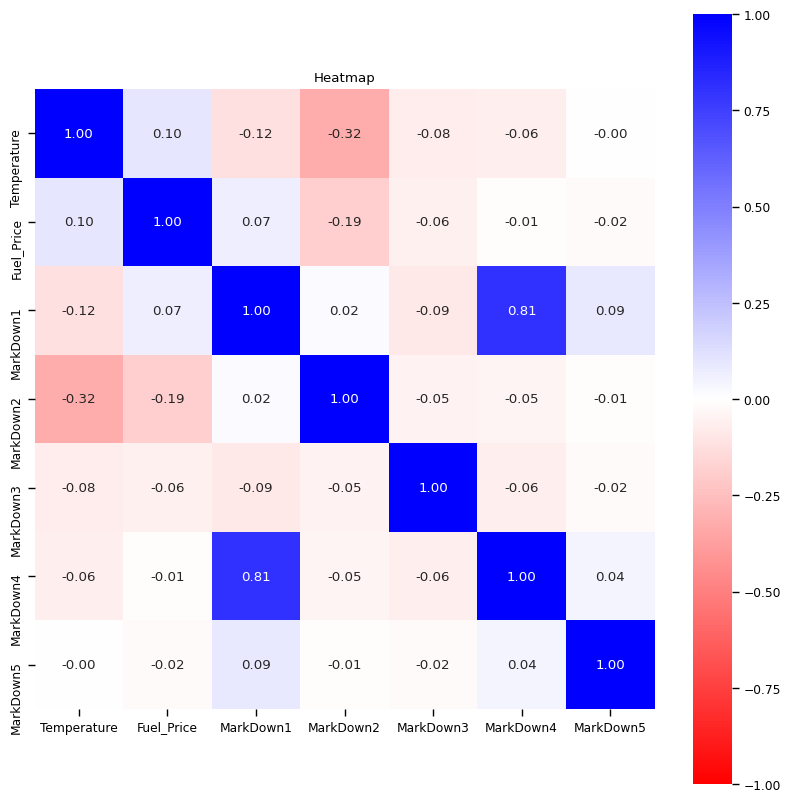

In [13]:
cols = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
sns.set_context('paper')
fig = plt.subplots(figsize=(10, 10))
plt.title(f"Heatmap")
sns.heatmap(features[cols].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='bwr_r', square=True)
plt.show()

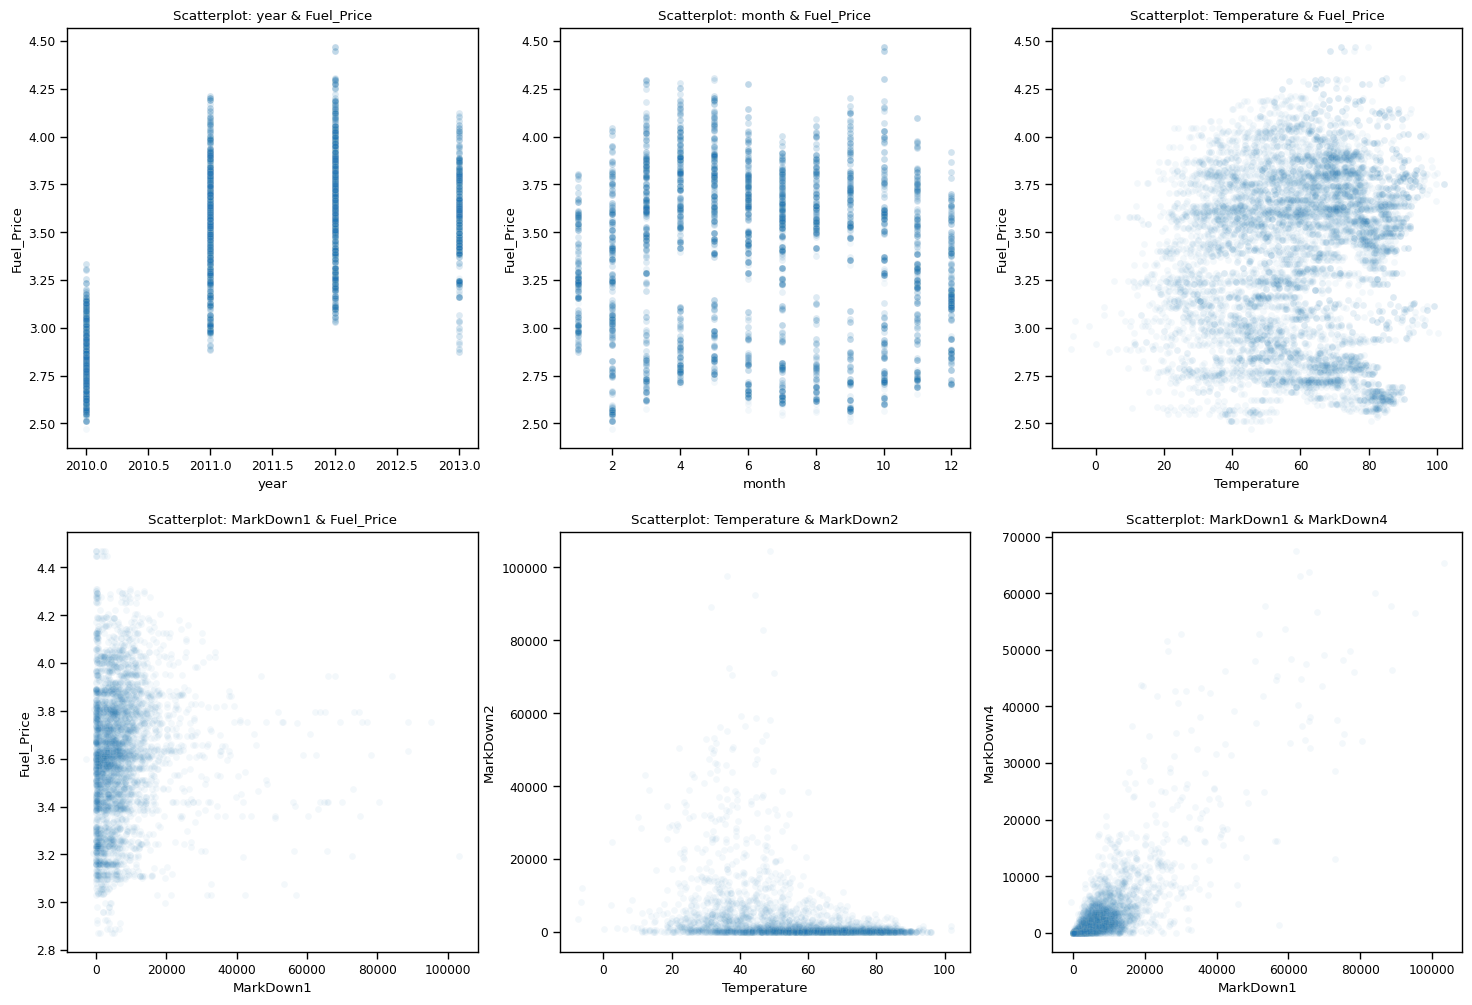

In [14]:
_, axes = plt.subplots(2, 3, figsize=(18,12))
axes = axes.ravel()
for i, col in enumerate(['year', 'month', 'Temperature', 'MarkDown1']):
    sns.scatterplot(data=features, x=col, y='Fuel_Price', alpha=0.05, ax=axes[i]) # hue=**
    # axes[i].legend(loc='upper right')
    axes[i].set_title(f"Scatterplot: {col} & Fuel_Price")
sns.scatterplot(data=features, x='Temperature', y='MarkDown2', alpha=0.05, ax=axes[4])
sns.scatterplot(data=features, x='MarkDown1', y='MarkDown4', alpha=0.05, ax=axes[5])
axes[4].set_title(f"Scatterplot: Temperature & MarkDown2")
axes[5].set_title(f"Scatterplot: MarkDown1 & MarkDown4")
plt.show()

In [15]:
def msno_matrix(df):
    df_ = df.copy()
    missing_ratios = df_.notnull().mean() * 100
    df_.columns = [f"{col}\n{ratio:.1f}%" for col, ratio in zip(df_.columns, missing_ratios)]
    msno.matrix(df_)
    plt.title('Missing Value Matrix and Percentage of Complete Values', fontsize=20)
    plt.show()

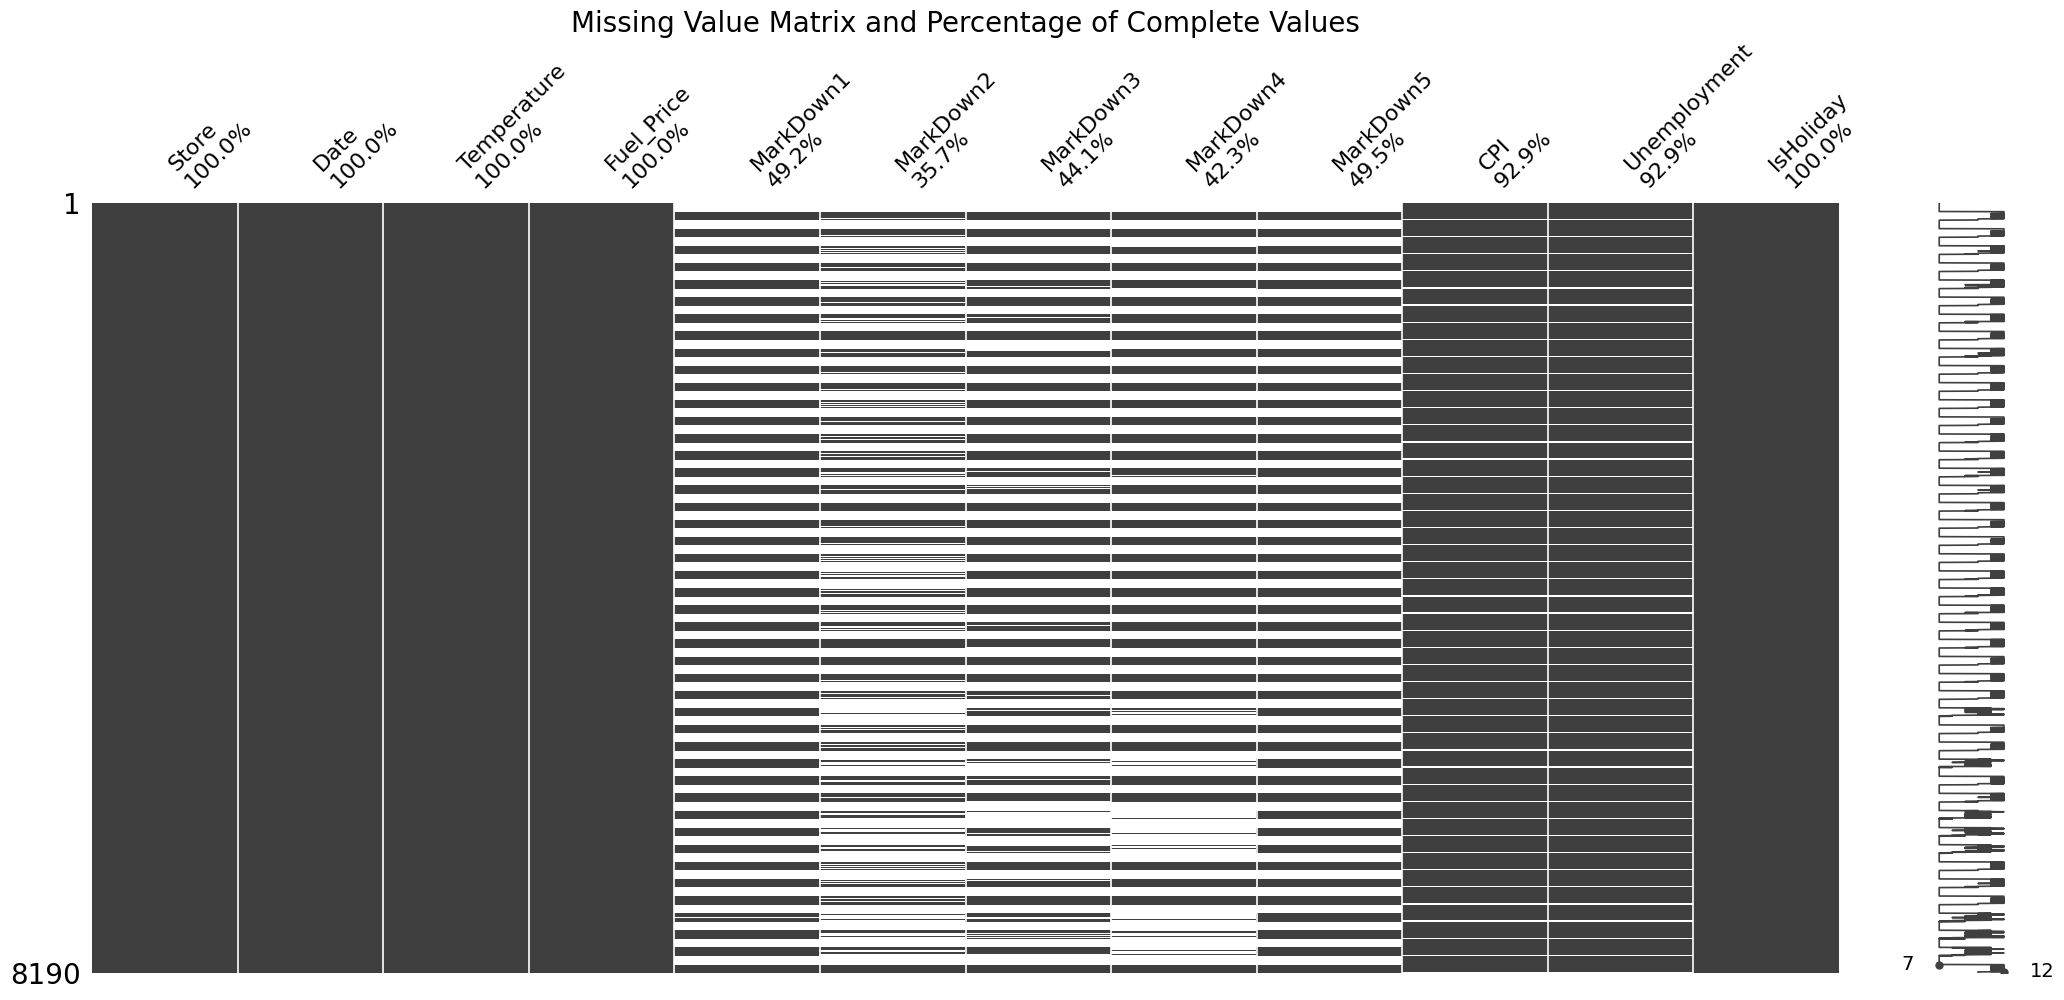

In [16]:
msno_matrix(FEATURES)

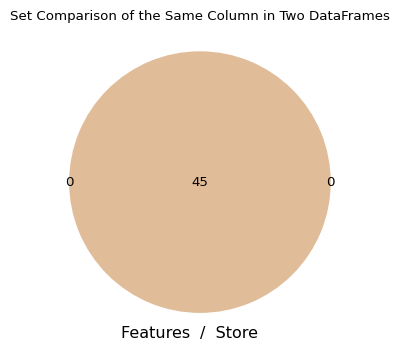

In [17]:
col = 'Store'

_, axes = plt.subplots(1, 1, figsize=(4,4))
# plt.subplots_adjust(hspace=0.6)
# axes = axes.ravel()
venn2([set(features[col]), set(stores[col])], ('Features  ', f"/  {col}"), ax=axes)
axes.set_title('Set Comparison of the Same Column in Two DataFrames')
plt.show()

In [40]:
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    features[f"{col}_log"] = np.log(features[col] - features[col].min() + 1)
    features[f"{col}_boxcox"] = np.nan
    features.loc[features[col].notna(), f"{col}_boxcox"], _ = stats.boxcox(features[features[col].notna()][col] - features[col].min() + 1)
    features[f"{col}_yeojohnson"] = np.nan
    features.loc[features[col].notna(), f"{col}_yeojohnson"], _ = stats.yeojohnson(features[features[col].notna()][col])

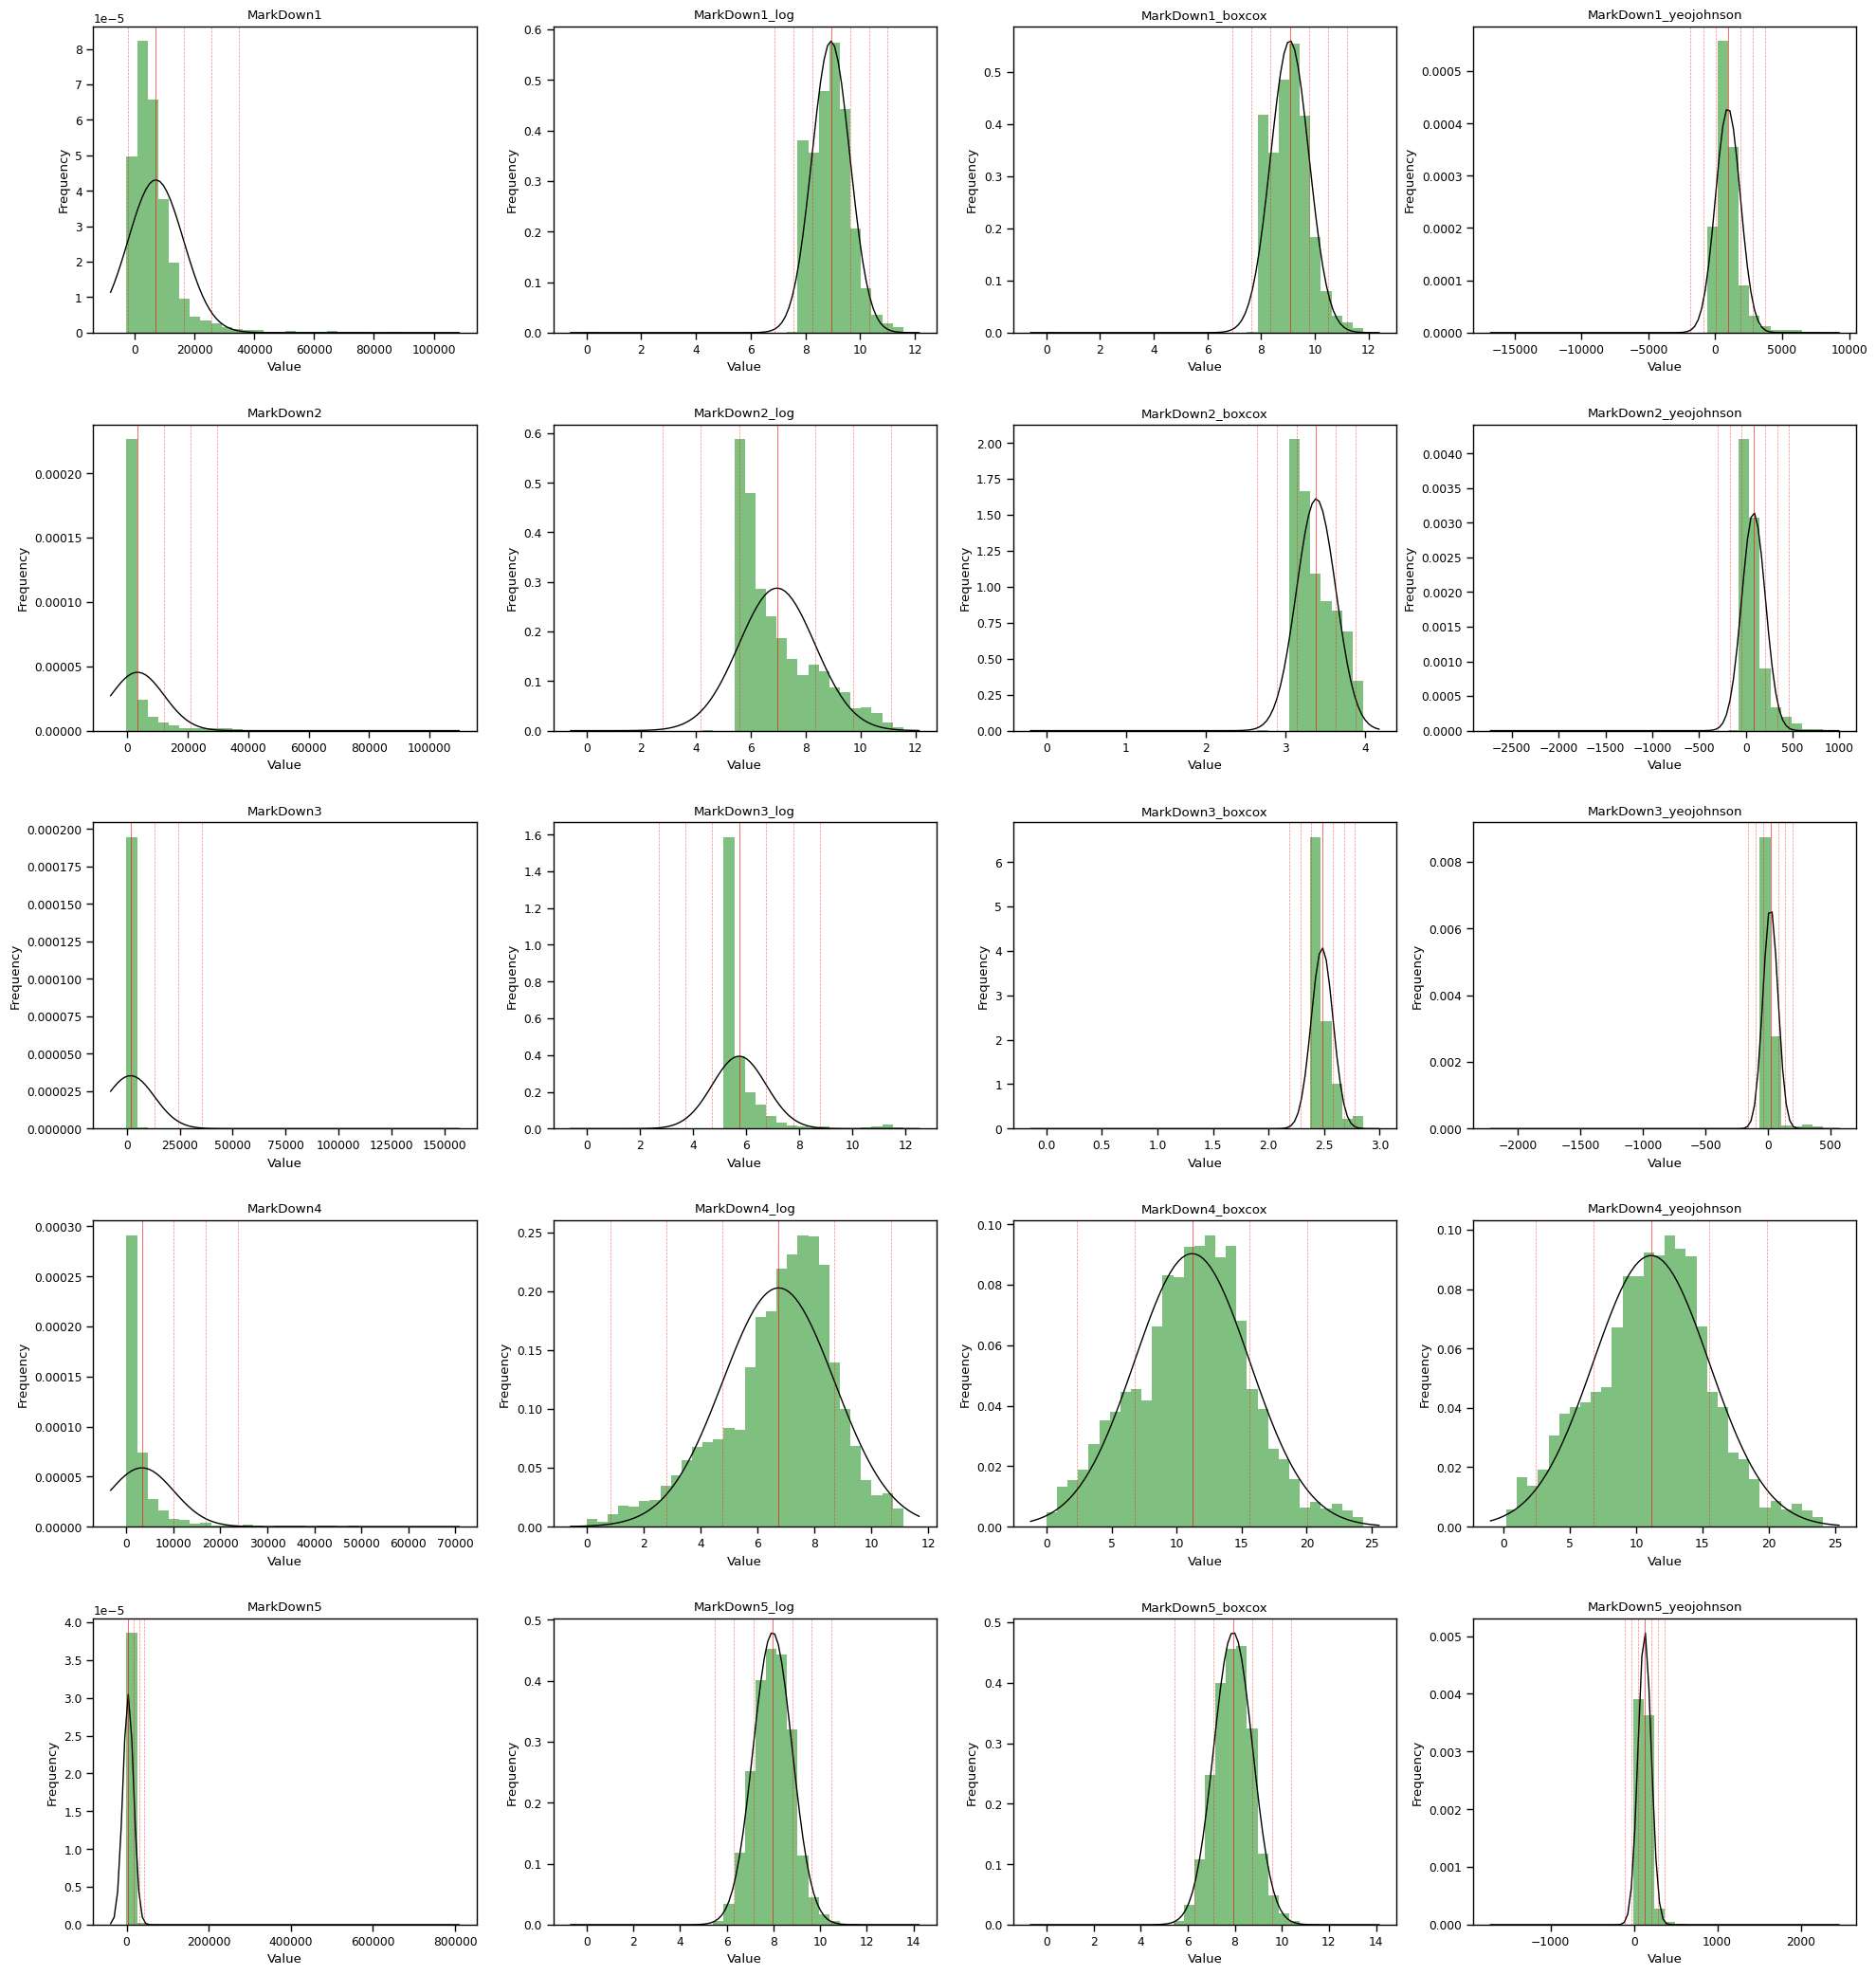

In [58]:
_, axes = plt.subplots(5, 4, figsize=(24,26))
plt.subplots_adjust(hspace=0.3)
for i, row in enumerate(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']):
    for j, col in enumerate(['', '_log', '_boxcox', '_yeojohnson']):
        ser = features[row+col]
        axes[i,j].hist(ser, bins=30, alpha=0.5, color='g', density=True)

        # 線形近似曲線（正規分布曲線）を追加
        mean = np.mean(ser)
        std = np.std(ser)
        xmin, xmax = axes[i,j].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mean, std)
        axes[i,j].plot(x, p, 'k', linewidth=1)

        # 標準偏差（σ）の範囲をプロット
        for k in range(4):
            linestyle = 'dashed' if k != 0 else 'solid'
            s = mean + k * std
            if s <= ser.max():
                axes[i,j].axvline(s, color='r', linestyle=linestyle, linewidth=0.5, alpha=0.5) # label=f'{i}σ' if i == 1 else ""
            s = mean - k * std
            if s >= ser.min():
                axes[i,j].axvline(s, color='r', linestyle=linestyle, linewidth=0.5, alpha=0.5)

        # Histogram with Linear Approximation Curve and Standard Deviations
        axes[i,j].set_title(ser.name)
        axes[i,j].set_xlabel('Value')
        axes[i,j].set_ylabel('Frequency')